In [8]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import gzip
from pybedtools import BedTool
import os
from tqdm import tqdm
import sys
sys.path.append('/project2/mstephens/cfbuenabadn/gtex-stm/code')
sys.path.append('/project2/mstephens/cfbuenabadn/gtex-stm/code/scripts')
from get_unique_region_counts import *
from sNMF_plots import *
from get_isoforms import *
from get_unique_region_counts import *
from plot_factors import *
from sklearn.preprocessing import scale

import rpy2
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
import rpy2.robjects.packages as rpackages


def load_ebpmf_gene(gene_id):
    readRDS = ro.r['readRDS']
    df = readRDS(f'/project2/mstephens/cfbuenabadn/gtex-stm/code/ebpmf_models/filtered/RDS/{gene_id}.rds')
    with (ro.default_converter + pandas2ri.converter).context():
        pd_from_r_df = ro.conversion.get_conversion().rpy2py(df)

    output = pd_from_r_df

    return output


def load_fasttopics_gene(gene_id):
    readRDS = ro.r['readRDS']
    df = readRDS(f'/project2/mstephens/cfbuenabadn/gtex-stm/code/fasttopics_models/{gene_id}.rds')
    with (ro.default_converter + pandas2ri.converter).context():
        pd_from_r_df = ro.conversion.get_conversion().rpy2py(df)

    output = pd_from_r_df

    return output

colores = np.array(sns.color_palette("tab10"))



In [2]:
counts = pd.read_csv('../code/coverage/counts_filtered/ENSG00000112081.csv.gz', index_col=0)
counts.index = [x.split('.')[0] for x in counts.index]
samples = pd.read_csv('../code/config/samples.tsv', sep='\t', index_col=0)
transcript_EL = pd.read_csv('../code/ebpmf_models/filtered/snmf_5/tables/transcript.3prime_corrected.EL.bed.gz', sep='\t', index_col=3)

In [3]:
tissues = sorted(['Brain_Anterior_cingulate_cortex_BA24',
 'Brain_Cortex',
 'Brain_Frontal_Cortex_BA9',
 'Brain_Putamen_basal_ganglia',
           'Skin_Not_Sun_Exposed_Suprapubic',
           'Liver',
 'Lung', 'Heart_Atrial_Appendage', 'Muscle_Skeletal','Whole_Blood'
          ])

sorted_samples = []
for t in tissues:
    sorted_samples.extend(list(transcript_EL.columns.intersection(samples.loc[samples.tissue_id == t].index)))

colors_list = ['goldenrod', 'gold', 'yellow', 'khaki', 'darkviolet', 'tab:green', 'mediumblue', 
            'lightsalmon', 'turquoise', 'tab:red']

tissue_list_names = ['Brain Anterior cingulate cortex BA24',
 'Brain Cortex',
 'Brain Frontal Cortex BA9',
 'Brain Putamen basal ganglia',
 'Heart Atrial Appendage',
 'Liver',
 'Lung',
 'Muscle Skeletal',
 'Skin Not Sun Exposed Suprapubic',
 'Whole Blood']

sample_slice = samples.loc[sorted_samples]

counts = counts.loc[sorted_samples]

In [52]:
def plot_factors_wrapper(X, gene, coords, ebpmf='ebpmf_10', strand='plus', colores=None, figsize=None, lm=True, factor_list = None, 
                         ax = None, xlim=None, plot_coords = False, lwidth=3, mute_y_axis = False):
    EF = pd.DataFrame(X)
    EF.index = coords

    
    
    EF.columns = [f'factor{str(i+1)}' for i in range(EF.shape[1])]

    if factor_list is not None:
        EF = EF[factor_list]
        EF = pd.DataFrame(EF)
        K = EF.shape[1]
        EF.columns = [f'factor{str(i)}' for i in range(1, K+1)]
    
    for factor in EF.columns:
        y = np.array(EF[factor])
        EF[factor] = y
    plot_factor_tracks(EF/EF.quantile(0.99, axis=0), gene, EF.shape[1], colores = colores, figsize=figsize, ax=ax, 
                       xlim=xlim, plot_coords = plot_coords, mute_y_axis=mute_y_axis)


def plot_factor_tracks(EF, gene, K, title=None, fill=True, smooth=False, colores = None, q=0.99, figsize=None, ax=None, xlim=None, 
                       plot_coords=None, lwidth=None, mute_y_axis=False):

    #EF = np.minimum(EF/EF.quantile(q, axis=0), 1)

    if colores is None:
        if K <= 5:
            colores = ['tab:blue', 'tab:orange', 'tab:green', 'goldenrod', 'tab:red'] 
        else:
            colores = sns.color_palette("tab10")
    
    if K <= 3:
        S = K
    else:
        S = K*0.8

    if figsize is None:
        figsize=(15, S)

    if ax is None:
        fig, ax = plt.subplots(nrows = K, figsize=figsize, gridspec_kw={'height_ratios': [2]*K, 
                                                                               'wspace': 0.3, 'hspace': 0.3})

    start = int(EF.index[0].split(':')[1])
    end = int(EF.index[-1].split(':')[1])
    length = EF.shape[0]
    
    coords = np.linspace(start, end, num=length)
    
    for i in range(K):
        factor = f'factor{i+1}'
        scaled_y = EF[factor]#/np.max(EF[factor])
        if fill:
            ax[i].fill_between(coords, np.zeros(len(coords)), scaled_y, color=colores[i], alpha=0.3)
#         else:
        ax[i].plot(coords, scaled_y, c=colores[i], alpha=0.9, linewidth=lwidth)
        
        ax[i].spines['top'].set_visible(False)
        ax[i].spines['right'].set_visible(False)
        if (i < K-1) or (not plot_coords):
            ax[i].set_xticks([])
            ax[i].spines['bottom'].set_visible(False)

        if mute_y_axis:
            ax[i].spines['left'].set_visible(False)
            ax[i].set_yticks([])

        ax[i].set_xlim([xlim[0], xlim[1]])
        
        #ax[i].text(start+((end-start)*1.1), 0.9, factor, size=12)

    
        
    if title:
        fig.suptitle(title, fontsize=12, x=0.5, y=1.1)

    


###############

def plot_isoform_annotations(annotation_exons, gene, colores=None, start=None, end=None, figsize=None, lwidth=5, iso_order=None, axes=None, xlim=None):

    gene_exons = annotation_exons.loc[annotation_exons.gene_id == gene]

    if iso_order is None:
        isoforms = sorted(gene_exons.transcript_id.unique())
    else:
        isoforms = [gene + '.' + x for x in iso_order]

    isoform_dict = {}
    for i, iso in enumerate(isoforms):
        isoform_name = f'isoform_{str(i+1)}'
        df = gene_exons.loc[gene_exons.transcript_id == iso].copy()
        df['transcript_id'] =  f'{gene}.{isoform_name}'
        isoform_dict.update({isoform_name:{'df':df}})

    chrom = list(annotation_exons.chrom)[0]
    if start is None:
        start = str(np.min([int(list(gene_exons.start)[0]), int(list(gene_exons.start)[0])]) - 1000)
    if end is None:
        end = str(np.max([int(list(gene_exons.end)[-1]), int(list(gene_exons.end)[-1])]) + 1000)

    coords = [f'{chrom}:{start}', f'{chrom}:{end}']

    # print(isoform_dict)

    plot_gene_isoforms(isoform_dict, coords, color_list = colores, figsize=figsize, lwidth=lwidth, axes=axes, xlim=xlim)


def plot_gene_isoforms(isoforms_dict, coordinates, color_list = None, axes=None, figsize=None, lwidth=5, xlim=None):

    if xlim is None:
        xlim1 = int(coordinates[0].split(':')[1])
        xlim2 = int(coordinates[-1].split(':')[1])
    else:
        xlim1 = xlim[0]
        xlim2 = xlim[1]
    

    if color_list is None:
        color_list = sns.color_palette("tab10")

    K = len(isoforms_dict)

    if figsize is None:
        figsize=(20, 3)

    if axes is None:
        fig, axes = plt.subplots(K, 1, figsize=figsize)

    for i in range(K):
        isoform_df = isoforms_dict[f'isoform_{str(i+1)}']['df']
        # print(isoform_df)
        ax = axes[i]
        color = color_list[i]
        plot_isoform(isoform_df, ax, color, xlim[0], xlim[1], lwidth=lwidth)


def plot_isoform(isoform_df, ax, color, xlim1, xlim2, lwidth):
    # print(isoform_df)
    is_first = True
    for idx, row in isoform_df.iterrows():
        start = int(row.start)
        end = int(row.end)
        if is_first:
            first = end
            is_first = False
    
        ax.fill_between([start, end], [0, 0], [1, 1], color = color, zorder=2)
    
    ax.plot([first, start], [0.5, 0.5], c=color, linewidth=lwidth)

    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines[['bottom', 'top', 'right', 'left']].set_visible(False)
    ax.set_xlim([xlim1, xlim2])

    # print(xlim1, xlim2)



In [106]:
import numpy as np
from sklearn.decomposition import PCA
pca = PCA(n_components=5)

X = scale(np.log1p(counts), axis=1).T
pca.fit(X)
principal_components = pca.transform(X)

# Loadings
loadings = pca.components_

In [50]:
rds = load_ebpmf_gene('ENSG00000112081')
colores = sns.color_palette("tab10", 8)



xlim1 = int(rds['ebpmf_5']['coords'][0].split(':')[1])-1000
xlim2 = int(rds['ebpmf_5']['coords'][-1].split(':')[1])+1000
xlim = (xlim1, xlim2)

coords = rds['ebpmf_5']['coords']

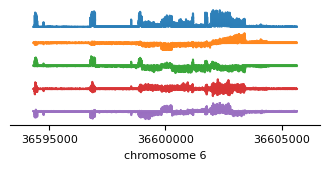

In [107]:
fig, ax = plt.subplots(nrows = 6, figsize=(4, 1.5), gridspec_kw={'height_ratios': [1.5]*5 + [0.01], 
                                                                               'wspace': 0.3, 'hspace': 0.3})





plot_factors_wrapper(principal_components, 'ENSG00000112081', coords, 'ebpmf_5', colores=colores, ax=ax[:5], xlim=xlim, lwidth=1, mute_y_axis=True, lm=True)
                     # factor_list = ['factor1', 'factor3', 'factor4', 'factor2', 'factor5'])

ax[5].spines['top'].set_visible(False)
ax[5].spines['right'].set_visible(False)
ax[5].spines['left'].set_visible(False)
ax[5].set_yticks([])
ax[5].set_xlim(xlim)
ax[5].set_xticks([36595000, 36600000, 36605000])
ax[5].set_xticklabels(['36595000', '36600000', '36605000'])
ax[5].tick_params(labelsize=8)
ax[5].set_xlabel('chromosome 6', fontsize=8)


plt.savefig('../code/scratch_figures/figure1/Fig1B/SRSF3.PCA_5.pdf', bbox_inches='tight')
plt.savefig('../code/scratch_figures/figure1/Fig1B/SRSF3.PCA_5.png', bbox_inches='tight', dpi=500)

In [108]:
import numpy as np
from sklearn.decomposition import PCA
pca = PCA(n_components=10)

X = scale(np.log1p(counts), axis=1).T
pca.fit(X)
principal_components = pca.transform(X)

# Loadings
loadings = pca.components_

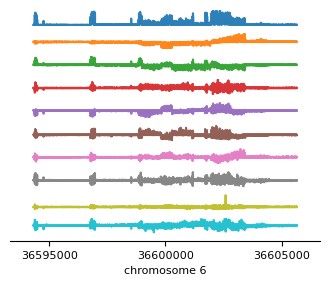

In [109]:
fig, ax = plt.subplots(nrows = 11, figsize=(4, 3), gridspec_kw={'height_ratios': [1.5]*10 + [0.01], 
                                                                               'wspace': 0.3, 'hspace': 0.5})





plot_factors_wrapper(principal_components, 'ENSG00000112081', coords, 'ebpmf_5', colores=colores, ax=ax[:10], xlim=xlim, lwidth=1, mute_y_axis=True, lm=True)
                     # factor_list = ['factor1', 'factor3', 'factor4', 'factor2', 'factor5'])

ax[10].spines['top'].set_visible(False)
ax[10].spines['right'].set_visible(False)
ax[10].spines['left'].set_visible(False)
ax[10].set_yticks([])
ax[10].set_xlim(xlim)
ax[10].set_xticks([36595000, 36600000, 36605000])
ax[10].set_xticklabels(['36595000', '36600000', '36605000'])
ax[10].tick_params(labelsize=8)
ax[10].set_xlabel('chromosome 6', fontsize=8)

plt.savefig('../code/scratch_figures/figure1/Fig1B/SRSF3.PCA_10.pdf', bbox_inches='tight')
plt.savefig('../code/scratch_figures/figure1/Fig1B/SRSF3.PCA_10.png', bbox_inches='tight', dpi=500)

/project2/yangili1/cfbuenabadn/envs/rpython/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1770: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


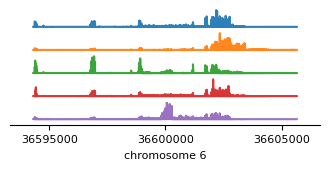

In [110]:
import numpy as np
X = counts
from sklearn.decomposition import NMF
model = NMF(n_components=5, init='random', random_state=0)
W = model.fit_transform(X)
H = model.components_


colores = np.array(sns.color_palette("tab10"))

fig, ax = plt.subplots(nrows = 6, figsize=(4, 1.5), gridspec_kw={'height_ratios': [1.5]*5 + [0.01], 
                                                                               'wspace': 0.3, 'hspace': 0.3})





plot_factors_wrapper(H.T, 'ENSG00000112081', coords, 'ebpmf_5', colores=colores, ax=ax[:5], xlim=xlim, lwidth=1, mute_y_axis=True, lm=True)
                     # factor_list = ['factor1', 'factor3', 'factor4', 'factor2', 'factor5'])

ax[5].spines['top'].set_visible(False)
ax[5].spines['right'].set_visible(False)
ax[5].spines['left'].set_visible(False)
ax[5].set_yticks([])
ax[5].set_xlim(xlim)
ax[5].set_xticks([36595000, 36600000, 36605000])
ax[5].set_xticklabels(['36595000', '36600000', '36605000'])
ax[5].tick_params(labelsize=8)
ax[5].set_xlabel('chromosome 6', fontsize=8)


plt.savefig('../code/scratch_figures/figure1/Fig1B/SRSF3.NMF_5.pdf', bbox_inches='tight')
plt.savefig('../code/scratch_figures/figure1/Fig1B/SRSF3.NMF_5.png', bbox_inches='tight', dpi=500)

In [111]:
import numpy as np
X = np.log1p(counts)
from sklearn.decomposition import NMF
model = NMF(n_components=10, init='random', random_state=0)
W = model.fit_transform(counts)
H = model.components_

/project2/yangili1/cfbuenabadn/envs/rpython/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1770: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


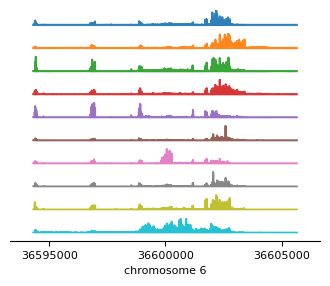

In [112]:
colores = np.array(sns.color_palette("tab10"))

fig, ax = plt.subplots(nrows = 11, figsize=(4, 3), gridspec_kw={'height_ratios': [1.5]*10 + [0.01], 
                                                                               'wspace': 0.3, 'hspace': 0.5})





plot_factors_wrapper(H.T, 'ENSG00000112081', coords, 'ebpmf_5', colores=colores, ax=ax[:10], xlim=xlim, lwidth=1, mute_y_axis=True, lm=True)
                     # factor_list = ['factor1', 'factor3', 'factor4', 'factor2', 'factor5'])

ax[10].spines['top'].set_visible(False)
ax[10].spines['right'].set_visible(False)
ax[10].spines['left'].set_visible(False)
ax[10].set_yticks([])
ax[10].set_xlim(xlim)
ax[10].set_xticks([36595000, 36600000, 36605000])
ax[10].set_xticklabels(['36595000', '36600000', '36605000'])
ax[10].tick_params(labelsize=8)
ax[10].set_xlabel('chromosome 6', fontsize=8)


plt.savefig('../code/scratch_figures/figure1/Fig1B/SRSF3.NMF_10.pdf', bbox_inches='tight')
plt.savefig('../code/scratch_figures/figure1/Fig1B/SRSF3.NMF_10.png', bbox_inches='tight', dpi=500)

In [80]:
rds = load_fasttopics_gene('ENSG00000112081')

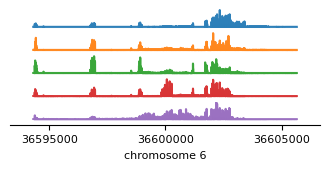

In [116]:
F = rds['fasttopics_5']['F']

colores = np.array(sns.color_palette("tab10"))

fig, ax = plt.subplots(nrows = 6, figsize=(4, 1.5), gridspec_kw={'height_ratios': [1.5]*5 + [0.01], 
                                                                               'wspace': 0.3, 'hspace': 0.3})





plot_factors_wrapper(F.T[[0, 2, 3,1, 4],1:11339].T, 'ENSG00000112081', coords, 'ebpmf_5', colores=colores, ax=ax[:5], xlim=xlim, lwidth=1, mute_y_axis=True, lm=True)
                     # factor_list = ['factor1', 'factor3', 'factor4', 'factor2', 'factor5'])

ax[5].spines['top'].set_visible(False)
ax[5].spines['right'].set_visible(False)
ax[5].spines['left'].set_visible(False)
ax[5].set_yticks([])
ax[5].set_xlim(xlim)
ax[5].set_xticks([36595000, 36600000, 36605000])
ax[5].set_xticklabels(['36595000', '36600000', '36605000'])
ax[5].tick_params(labelsize=8)
ax[5].set_xlabel('chromosome 6', fontsize=8)



plt.savefig('../code/scratch_figures/figure1/Fig1B/SRSF3.fasttopics_5.pdf', bbox_inches='tight')
plt.savefig('../code/scratch_figures/figure1/Fig1B/SRSF3.fasttopics_5.png', bbox_inches='tight', dpi=500)

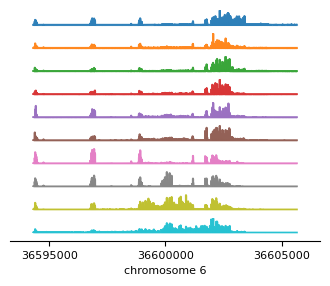

In [117]:
F = rds['fasttopics_10']['F']

colores = np.array(sns.color_palette("tab10"))

fig, ax = plt.subplots(nrows = 11, figsize=(4, 3), gridspec_kw={'height_ratios': [1.5]*10 + [0.01], 
                                                                               'wspace': 0.3, 'hspace': 0.5})



# ['factor1', 'factor6', 'factor7', 'factor10', 'factor3', 'factor5',  'factor4', 
#                                    'factor9', 'factor8', 'factor2']


plot_factors_wrapper(F.T[[0, 5, 6, 9, 2, 4, 3, 8, 7, 1],1:11339].T, 
                     'ENSG00000112081', coords, 'ebpmf_5', colores=colores, ax=ax[:10], xlim=xlim, lwidth=1, mute_y_axis=True, lm=True)
                     # factor_list = ['factor1', 'factor3', 'factor4', 'factor2', 'factor5'])

ax[10].spines['top'].set_visible(False)
ax[10].spines['right'].set_visible(False)
ax[10].spines['left'].set_visible(False)
ax[10].set_yticks([])
ax[10].set_xlim(xlim)
ax[10].set_xticks([36595000, 36600000, 36605000])
ax[10].set_xticklabels(['36595000', '36600000', '36605000'])
ax[10].tick_params(labelsize=8)
ax[10].set_xlabel('chromosome 6', fontsize=8)

plt.savefig('../code/scratch_figures/figure1/Fig1B/SRSF3.fasttopics_10.pdf', bbox_inches='tight')
plt.savefig('../code/scratch_figures/figure1/Fig1B/SRSF3.fasttopics_10.png', bbox_inches='tight', dpi=500)